# Описание данных

Бортовой набор данных DeepSat (SAT-4)

Первоначально изображения были извлечены из набора данных Национальной программы создания изображений сельского хозяйства (NAIP). Набор данных NAIP состоит в общей сложности из 330 000 сцен, охватывающих всю Континентальную часть Соединенных Штатов (CONUS). Авторы использовали несжатые цифровые ортоквартальные квадратики (DOQQs), которые представляют собой изображения GeoTIFF, а площадь соответствует топографическим четырехугольникам Геологической службы США (USGS). Средние фрагменты изображения имеют ~ 6000 пикселей в ширину и ~ 7000 пикселей в высоту, размером около 200 мегабайт каждый. Весь набор данных NAIP для CONUS составляет ~ 65 терабайт. Изображения получены на расстоянии 1 м от образца грунта (GSD) с горизонтальной точностью, которая находится в пределах шести метров от фотоидентифицируемых наземных контрольных точек.

Изображения состоят из 4 полос - красной, зеленой, синей и ближней инфракрасной (NIR). Чтобы сохранить высокую дисперсию, присущую всему набору данных NAIP, мы отбираем фрагменты изображений из множества сцен (всего 1500 фрагментов изображений), охватывающих различные ландшафты, такие как сельская местность, городские районы, густо поросшие лесом, гористая местность, небольшие и крупные водоемы, сельскохозяйственные районы и т.д., охватывающие весь штат Калифорния. Инструмент маркировки изображений, разработанный в рамках этого исследования, использовался для ручной маркировки однородных участков изображения, принадлежащих к определенному классу почвенного покрова.

После маркировки неперекрывающиеся блоки скользящего окна 28x28 были извлечены из участка однородного изображения и сохранены в наборе данных с соответствующей меткой. Мы выбрали 28x28 в качестве размера окна, чтобы сохранить значительно больший контекст и в то же время не делать его таким большим, чтобы исключить относительные статистические свойства условных распределений целевого класса в контекстном окне. Были приняты меры для предотвращения перекрытия между классами в пределах выбранного и помеченного участка изображения.

Содержание

    Каждый образец изображения имеет размер 28x28 пикселей и состоит из 4 полос - красной, зеленой, синей и ближней инфракрасной.

    Обучающие и тестовые метки представляют собой векторы формата 1x4, закодированные одним нажатием кнопки

    Четыре класса представляют четыре обширных растительных покрова, которые включают бесплодные земли, деревья, луга и класс, состоящий из всех классов растительного покрова, кроме трех вышеупомянутых.

    Обучающий и тестовый наборы данных принадлежат к непересекающемуся набору фрагментов изображений.

    Размер каждого участка изображения нормализован до 28x28 пикселей.

    После создания обучающий и тестовый наборы данных были рандомизированы с использованием генератора псевдослучайных чисел.

CSV-файлы

X_train_sat4.csv: 400 000 обучающих изображений, 28x28 изображений каждое с 4 каналами

y_train_sat4.csv: 400 000 обучающих меток, векторы с однократным кодированием 1x4

X_test_sat4.csv: 100 000 обучающих изображений, 28x28 изображений каждое с 4 каналами

y_test_sat4.csv: 100 000 обучающих меток, векторы с однократным кодированием 1x4

## Библиотеки 

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")

2024-08-29 17:27:32.103013: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-29 17:27:32.150981: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-29 17:27:33.009748: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("TensorFlow использует GPU:", physical_devices)
else:
    print("TensorFlow использует CPU")

TensorFlow использует CPU


2024-08-29 17:27:34.544553: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### Подготовка данных

In [3]:
X_train = pd.read_csv('/home/jupyter/datasphere/project/X_train_sat4.csv', header=None, nrows=400000)
y_train = pd.read_csv('/home/jupyter/datasphere/project/y_train_sat4.csv', header=None, nrows=400000)
X_test = pd.read_csv('/home/jupyter/datasphere/project/X_test_sat4.csv', header=None, nrows=100000)
y_test = pd.read_csv('/home/jupyter/datasphere/project/y_test_sat4.csv', header=None, nrows=100000)

print(f'Размеры X_train: {X_train.shape}')
print(f'Размеры y_train: {y_train.shape}')
print(f'Размеры X_test: {X_test.shape}')
print(f'Размеры y_test: {y_test.shape}')

Размеры X_train: (400000, 3136)
Размеры y_train: (400000, 4)
Размеры X_test: (100000, 3136)
Размеры y_test: (100000, 4)


In [4]:
# Нормализация данных и преобразование формы
X_train_reshaped = X_train.values.reshape(-1, 28, 28, 4) / 255.0
X_test_reshaped = X_test.values.reshape(-1, 28, 28, 4) / 255.0

# Преобразование меток в категорические значения
y_train_labels = np.argmax(y_train.values, axis=1)
y_train_categorical = to_categorical(y_train_labels, num_classes=4)
y_test_labels = np.argmax(y_test.values, axis=1)
y_test_categorical = to_categorical(y_test_labels, num_classes=4)

X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_reshaped, y_train_categorical, test_size=0.2, random_state=29082024)

In [5]:
print(f'Размеры X_train: {X_train_final.shape}')
print(f'Размеры y_train: {y_train_final.shape}')
print(f'Размеры X_val: {X_val.shape}')
print(f'Размеры y_val: {y_val.shape}')
print(f'Размеры X_test: {X_test_reshaped.shape}')
print(f'Размеры y_test: {y_test_categorical.shape}')

Размеры X_train: (320000, 28, 28, 4)
Размеры y_train: (320000, 4)
Размеры X_val: (80000, 28, 28, 4)
Размеры y_val: (80000, 4)
Размеры X_test: (100000, 28, 28, 4)
Размеры y_test: (100000, 4)


### Обучение модели

In [6]:
def train_model_with_fraction(fraction, use_all_data=False):
    if use_all_data:
        X_train_sample = X_train_reshaped
        y_train_sample = y_train_categorical
    else:
        X_train_sample, _, y_train_sample, _ = train_test_split(
            X_train_reshaped, y_train_categorical, 
            train_size=fraction, random_state=29082024
        )

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 4)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

    start_time = time.time()

    model.fit(
        X_train_sample, y_train_sample,
        validation_data=(X_val, y_val),
        epochs=5,
        batch_size=128,
        callbacks=[early_stopping, model_checkpoint],
        verbose=0
    )

    end_time = time.time()
    training_time = end_time - start_time
    
    data_fraction = '100%' if use_all_data else f'{fraction*100}%'
    print(f"Процент данных: {data_fraction}, время обучения: {training_time:.2f} секунд")
    
    return model, training_time


In [7]:
fractions = [0.05, 0.10, 0.20, 0.45, 0.70]
results = {}

for fraction in fractions:
    _, training_time = train_model_with_fraction(fraction)
    results[fraction * 100] = training_time

_, training_time_100 = train_model_with_fraction(fraction=None, use_all_data=True)
results[100] = training_time_100

Процент данных: 5.0%, время обучения: 18.25 секунд
Процент данных: 10.0%, время обучения: 26.99 секунд
Процент данных: 20.0%, время обучения: 39.67 секунд
Процент данных: 45.0%, время обучения: 75.39 секунд
Процент данных: 70.0%, время обучения: 109.52 секунд
Процент данных: 100%, время обучения: 159.92 секунд


#### Зависимость времени обучения от % данных

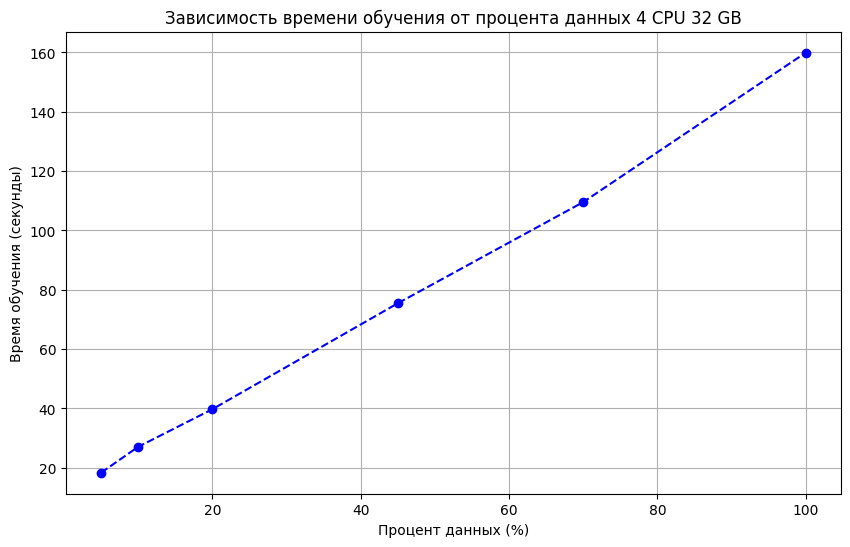

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(list(results.keys()), list(results.values()), marker='o', linestyle='--', color='b')
plt.title('Зависимость времени обучения от процента данных 4 CPU 32 GB')
plt.xlabel('Процент данных (%)')
plt.ylabel('Время обучения (секунды)')
plt.grid(True)
plt.show()


#### Зависимость времени обучения от числа вычислителей

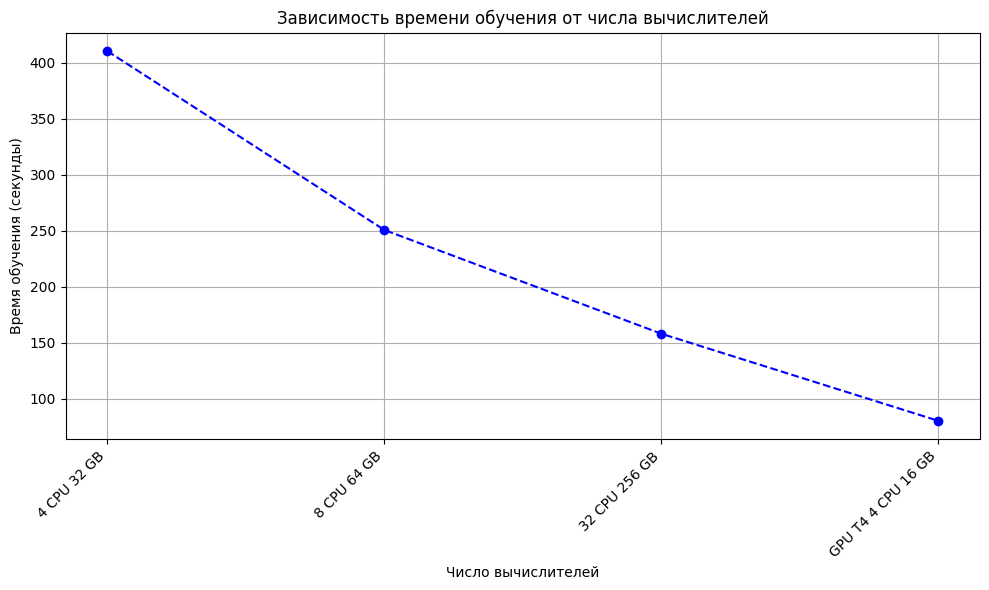

In [9]:
hardware_configs = [
    '4 CPU 32 GB',  
    '8 CPU 64 GB',  
    '32 CPU 256 GB',  
    'GPU T4 4 CPU 16 GB'  
]

training_times = [
    410.48,  
    250.80, 
    158.18,  
    80.43    
]

plt.figure(figsize=(10, 6))
plt.plot(hardware_configs, training_times, marker='o', linestyle='--', color='b')
plt.title('Зависимость времени обучения от числа вычислителей')
plt.xlabel('Число вычислителей')
plt.ylabel('Время обучения (секунды)')
plt.grid(True)
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()  
plt.show()

### Проверка на тестовых данных

In [11]:
model, _ = train_model_with_fraction(fraction=None, use_all_data=True)  
test_loss, test_acc = model.evaluate(X_test_reshaped, y_test_categorical)
print(f"Точность на тестовых данных: {test_acc:.4f}")
print(f"Потери на тестовых данных: {test_loss:.4f}")

Процент данных: 100%, время обучения: 159.57 секунд
3125/3125 [==============================] - 6s 2ms/step - loss: 0.0326 - accuracy: 0.9891
Точность на тестовых данных: 0.9891
Потери на тестовых данных: 0.0326
